# What is BioConductor?
Bioconductor is an ecosystem of R packages for analysing genomics data. According to bioconductor.org:

```
"Bioconductor provides tools for the analysis and comprehension of high-throughput genomic data. Bioconductor uses the R statistical programming language, and is open source and open development. It has two releases each year, and an active user community."
```

Bioconductor is an excellent source for annotation resources. I'll walk through using two of the most popular packages here -- `AnnotationHub` and `biomaRt`. `AnnotationHub` is a convenient interface to annotations from different resources and in many different formats. This includes annotations that are gene-centric (like OrgDbs) or genome-centric (like TxDbs), while `biomaRt` is mostly geared toward annotations from Ensembl. We will dig into these packages in more detail and these distinctions might make a little more sense as we move along.

For the purposes of this tutorial, we will be using the `airway` data. Four human airway smooth muscle cell lines were left untreated or treatreated with dexamethasone for 18 hours (Himes et al. 2014). I have already started procesing this data using DESeq2, we will load these objects and use them to look at a few different ways to query public annotation data and run some downstream analyses.

Much of this workshop is pulled from these resources:

https://www.bioconductor.org/packages/release/workflows/vignettes/annotation/inst/doc/Annotation_Resources.html                   
http://yulab-smu.top/clusterProfiler-book/           
https://bioconductor.org/packages/release/bioc/vignettes/AnnotationDbi/inst/doc/IntroToAnnotationPackages.pdf          

Let's load some packages:

In [127]:
BiocManager::install("BiocVersion")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.11 (BiocManager 1.30.12), R 4.0.3 (2020-10-10)

Installing package(s) 'BiocVersion'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'BH', 'bitops', 'boot', 'brio', 'callr', 'caTools', 'class',
  'cluster', 'crosstalk', 'crul', 'curl', 'data.table', 'DBI', 'deldir',
  'desc', 'diffobj', 'dplyr', 'dqrng', 'DT', 'ellipsis', 'fansi', 'farver',
  'fastmap', 'formatR', 'GGally', 'ggforce', 'ggplotify', 'ggraph', 'ggrepel',
  'glmnet', 'haven', 'highr', 'Hmisc', 'htmltools', 'httpuv', 'ipred',
  'IRdisplay', 'isoband', 'KernSmooth', 'knitr', 'later', 'lattice', 'lava',
  'leiden', 'lubridate', 'MASS', 'matrixStats', 'memoise', 'mgcv', 'mime',
  'mongolite', 'nlme', 'nnet', 'odbc', 'openssl', 'packrat', 'parallelly',
  'pbdZMQ', 'pkgload', 'PKI', 'plotly', 'pROC'

In [83]:
#BiocManager::install('DESeq2')
BiocManager::install('GenomicFeatures')
library("tidyverse")
library("ggplot2")
library("BiocManager")
library("gridExtra")
library("ggrepel")
library("airway")
library("AnnotationHub")
library("clusterProfiler")
library("enrichplot")
library("biomaRt")
library("DESeq2")
library("dplyr")
library("tidyr")
library("GenomicFeatures")

In [128]:
BiocManager::install(c('GenomicFeatures','Rhtslib', 'Rsamtools', 'GenomicAlignments', 'Biostrings', 'rtracklayer'))


'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.11 (BiocManager 1.30.12), R 4.0.3 (2020-10-10)

Installing package(s) 'GenomicFeatures', 'Rhtslib', 'Rsamtools',
  'GenomicAlignments', 'Biostrings', 'rtracklayer'

Warning message in install.packages(...):
“installation of package ‘Rhtslib’ had non-zero exit status”
Warning message in install.packages(...):
“installation of package ‘Biostrings’ had non-zero exit status”
Warning message in install.packages(...):
“installation of package ‘Rsamtools’ had non-zero exit status”
Warning message in install.packages(...):
“installation of package ‘GenomicAlignments’ had non-zero exit status”
Warning message in install.packages(...):
“installation of package ‘rtracklayer’ had non-zero exit status”
Warning message in install.packages(...):
“installation of package ‘GenomicFeatures’ had non-zero exit status”
Upd

Lets import some data to work with -- `res` is the `results` object and `rld` is the rlog transformed counts from DESeq2 differential expression analysis run on the `airway` data. We are comparing the dexamethasone treatment conditions, comparing treated to untreated.


In [84]:
res <- readRDS("res.rds")

In [85]:
res

log2 fold change (MAP): dex trt vs untrt 
Wald test p-value: dex trt vs untrt 
DataFrame with 29391 rows and 5 columns
                  baseMean log2FoldChange     lfcSE      pvalue       padj
                 <numeric>      <numeric> <numeric>   <numeric>  <numeric>
ENSG00000000003 708.602170     -0.3584541  0.100036 0.000152017 0.00128122
ENSG00000000419 520.297901      0.1860726  0.108183 0.065337210 0.19620790
ENSG00000000457 237.163037      0.0313468  0.130347 0.791504963 0.91119406
ENSG00000000460  57.932633     -0.0472622  0.212589 0.758803336 0.89463420
ENSG00000000938   0.318098     -0.0123431  0.309182 0.693732273         NA
...                    ...            ...       ...         ...        ...
ENSG00000273485   1.286448    -0.00445615  0.303747    0.936702         NA
ENSG00000273486  15.452537    -0.04309283  0.264183    0.756289   0.893661
ENSG00000273487   8.163235     0.19116398  0.355670    0.134373   0.329057
ENSG00000273488   8.584479     0.02194011  0.279542    0

In [86]:
rld <- readRDS("rld.rds")

In [87]:
rld

class: DESeqTransform 
dim: 29391 8 
metadata(2): '' version
assays(1): ''
rownames(29391): ENSG00000000003 ENSG00000000419 ... ENSG00000273488
  ENSG00000273489
rowData names(35): baseMean baseVar ... maxCooks rlogIntercept
colnames(8): SRR1039508 SRR1039509 ... SRR1039520 SRR1039521
colData names(10): SampleName cell ... BioSample sizeFactor

Let's work with the `res` results table. We can see that each row is a gene (`ENSG...`) and each column gives us some information about the differential expression analysis. These gene IDs are not particularly informative, but we can use biomaRt to fix that.

# Using biomaRt

The [biomaRt](https://bioconductor.org/packages/release/bioc/html/biomaRt.html) package makes it easy to query public repositories of biological data. We can use biomaRt to query Ensembl for annotations so that we can look for 'housekeeping genes' which are typically considered to be stably expressed and shouldn't show large variations across different samples. We have selected a list of genes based on two publications that queried public cancer genome data to find housekeeping genes for use with RNA-seq from cancer cell lines (https://doi.org/10.1186/s12859-019-2809-2, https://doi.org/10.3389/fgene.2019.00097). 

First, let's load biomaRt and make a vector of the gene symbols from the published data:

In [88]:
housekeeping <- c('PCBP1','RER1', 'RPN1', 'PUM1', 'IPO8')

Then we can see what BioMarts are available:

In [89]:
listMarts()

biomart,version
<chr>,<chr>
ENSEMBL_MART_ENSEMBL,Ensembl Genes 103
ENSEMBL_MART_MOUSE,Mouse strains 103
ENSEMBL_MART_SNP,Ensembl Variation 103
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 103


Let's use `ENSEMBL_MART_ENSEMBL` (you might get an error that says `Ensembl site unresponsive, trying uswest mirror`, run `?useEnsembl` to get more information about available options).

In [90]:
ensembl <- useEnsembl(biomart = 'ENSEMBL_MART_ENSEMBL', mirror = 'uswest')

Ensembl site unresponsive, trying asia mirror

Ensembl site unresponsive, trying www mirror



You can see a list of all available datasets within the mart:

In [91]:
datasets <- listDatasets(ensembl)
nrow(datasets)
head(datasets)

[1] 202

,dataset,description,version
,<I<chr>>,<I<chr>>,<I<chr>>
1,abrachyrhynchus_gene_ensembl,Pink-footed goose genes (ASM259213v1),ASM259213v1
2,acalliptera_gene_ensembl,Eastern happy genes (fAstCal1.2),fAstCal1.2
3,acarolinensis_gene_ensembl,Anole lizard genes (AnoCar2.0),AnoCar2.0
4,acchrysaetos_gene_ensembl,Golden eagle genes (bAquChr1.2),bAquChr1.2
5,acitrinellus_gene_ensembl,Midas cichlid genes (Midas_v5),Midas_v5
6,amelanoleuca_gene_ensembl,Giant panda genes (ASM200744v2),ASM200744v2


As you can see, there are many options available (202 of them). Let's try to narrow it down a little and only look for human datasets:

Then we can see which datasets are available for `hsapiens`

In [92]:
searchDatasets(mart = ensembl, pattern = 'hsapiens')

,dataset,description,version
,<I<chr>>,<I<chr>>,<I<chr>>
80,hsapiens_gene_ensembl,Human genes (GRCh38.p13),GRCh38.p13


Now we can put it all together to create a BioMart object: (you might get an error that says `Ensembl site unresponsive, trying uswest mirror`)

In [93]:
ensembl <- useEnsembl(biomart = 'ENSEMBL_MART_ENSEMBL', dataset='hsapiens_gene_ensembl', mirror = 'uswest')

In [94]:
ensembl

Object of class 'Mart':
  Using the ENSEMBL_MART_ENSEMBL BioMart database
  Using the hsapiens_gene_ensembl dataset

We can use the `listAttributes` function to see what information is available in `ensembl`

In [95]:
ensembl_attributes <- listAttributes(ensembl)
nrow(ensembl_attributes)
ensembl_attributes

[1] 3183

name,description,page
<chr>,<chr>,<chr>
ensembl_gene_id,Gene stable ID,feature_page
ensembl_gene_id_version,Gene stable ID version,feature_page
ensembl_transcript_id,Transcript stable ID,feature_page
ensembl_transcript_id_version,Transcript stable ID version,feature_page
ensembl_peptide_id,Protein stable ID,feature_page
ensembl_peptide_id_version,Protein stable ID version,feature_page
ensembl_exon_id,Exon stable ID,feature_page
description,Gene description,feature_page
chromosome_name,Chromosome/scaffold name,feature_page


Note that there are ~3000 attributes for this mart! We only care a about two -- `ensembl_gene_id` and `hgnc_symbol`.

We can use `getBM` to query the BioMart object, which is the main function of `biomaRt`. It takes the following arguments:

`attributes`: the attributes you want to retrieve                     
`filters`: the filters that should be used in the query                    
`values`: the values of the filters                    
`mart`: the mart object you want to use.                    

In [96]:
ensembl_bm <- getBM(
    attributes = c('ensembl_gene_id','hgnc_symbol'),
    filters = 'hgnc_symbol',
    values = housekeeping, 
    mart = ensembl)
ensembl_bm

ensembl_gene_id,hgnc_symbol
<chr>,<chr>
ENSG00000133704,IPO8
ENSG00000169564,PCBP1
ENSG00000134644,PUM1
ENSG00000157916,RER1
ENSG00000163902,RPN1


Let's look at the `rlog` normalized counts for our housekeeping genes:

In [97]:
housekeeping_rld <- data.frame(assay(rld)[ensembl_bm$ensembl_gene_id, ])
head(housekeeping_rld)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000133704,10.41685,10.23479,10.45273,10.39731,10.53719,10.48919,10.46832,10.45651
ENSG00000169564,10.48063,10.56330,10.22373,10.31371,10.16660,10.37503,10.39615,10.36473
ENSG00000134644,11.20999,11.22307,10.98335,11.12745,11.21067,11.24240,11.09791,11.22956
ENSG00000157916,10.98437,11.19663,11.00188,11.20675,10.98911,11.22096,10.93644,11.10573
ENSG00000163902,11.68383,11.83756,11.71771,11.89697,11.71163,12.04157,11.57565,11.70463


The `ensembl_gene_id` is currently stored as the rownames. Let's go ahead and turn it into a column in the data frame:

In [98]:
housekeeping_rld$ensembl_gene_id <- rownames(housekeeping_rld)
head(housekeeping_rld)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521,ensembl_gene_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000133704,10.41685,10.23479,10.45273,10.39731,10.53719,10.48919,10.46832,10.45651,ENSG00000133704
ENSG00000169564,10.48063,10.56330,10.22373,10.31371,10.16660,10.37503,10.39615,10.36473,ENSG00000169564
ENSG00000134644,11.20999,11.22307,10.98335,11.12745,11.21067,11.24240,11.09791,11.22956,ENSG00000134644
ENSG00000157916,10.98437,11.19663,11.00188,11.20675,10.98911,11.22096,10.93644,11.10573,ENSG00000157916
ENSG00000163902,11.68383,11.83756,11.71771,11.89697,11.71163,12.04157,11.57565,11.70463,ENSG00000163902


Then we use the `gather` function to convert the data to a long format.

In [99]:
housekeeping_rld_tidy <- gather(housekeeping_rld, key = 'sample', value = 'rlog_counts', SRR1039508:SRR1039521)
head(housekeeping_rld_tidy)

,ensembl_gene_id,sample,rlog_counts
,<chr>,<chr>,<dbl>
1,ENSG00000133704,SRR1039508,10.41685
2,ENSG00000169564,SRR1039508,10.48063
3,ENSG00000134644,SRR1039508,11.20999
4,ENSG00000157916,SRR1039508,10.98437
5,ENSG00000163902,SRR1039508,11.68383
6,ENSG00000133704,SRR1039509,10.23479


Let's add the annotation information we pulled from biomaRt:

In [100]:
housekeeping_rld_tidy <- inner_join(ensembl_bm, housekeeping_rld_tidy, by = 'ensembl_gene_id')
head(housekeeping_rld_tidy)

,ensembl_gene_id,hgnc_symbol,sample,rlog_counts
,<chr>,<chr>,<chr>,<dbl>
1,ENSG00000133704,IPO8,SRR1039508,10.41685
2,ENSG00000133704,IPO8,SRR1039509,10.23479
3,ENSG00000133704,IPO8,SRR1039512,10.45273
4,ENSG00000133704,IPO8,SRR1039513,10.39731
5,ENSG00000133704,IPO8,SRR1039516,10.53719
6,ENSG00000133704,IPO8,SRR1039517,10.48919


Let's look at the expression of our housekeeping genes to see if they look stably expressed in our data:

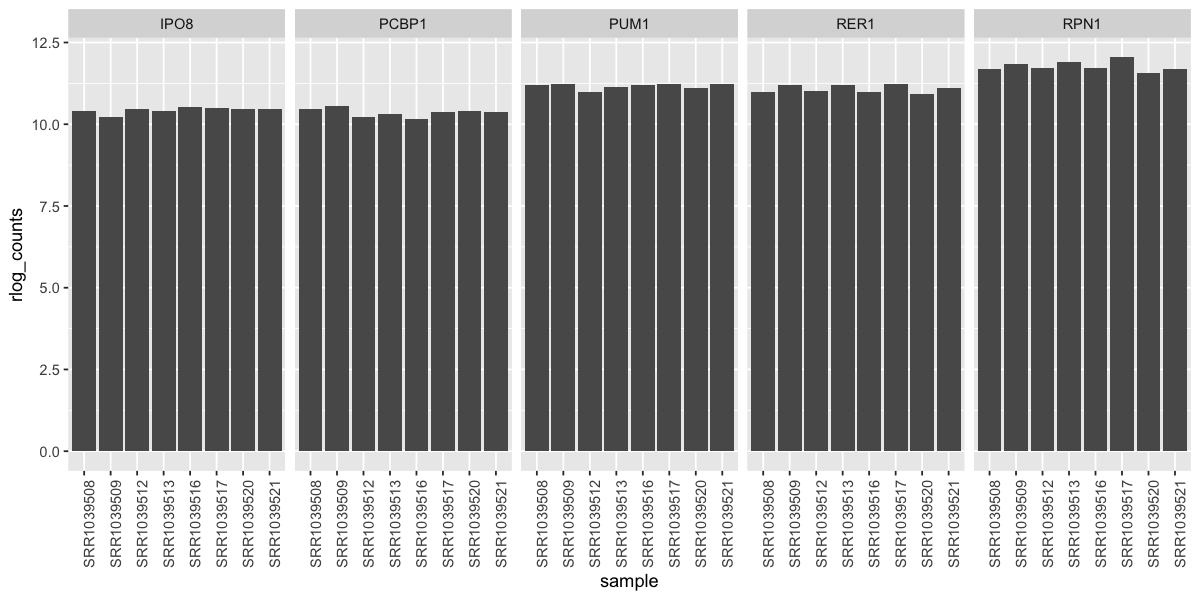

In [101]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(housekeeping_rld_tidy, aes(x=sample, y=rlog_counts)) + 
geom_bar(stat="identity") +
facet_wrap(~hgnc_symbol, nrow = 1) +
theme(axis.text.x = element_text(angle = 90))

These housekeeping genes look stably expressed across each sample.

# Using AnnotationHub

Now we can try using AnnotationHub to do something similar to what we just did with `biomaRt`. 
First, let's connect to the hub using `AnnotationHub` and look at the output.

In [102]:
ah <- AnnotationHub()
ah

snapshotDate(): 2020-04-27



AnnotationHub with 50515 records
# snapshotDate(): 2020-04-27
# $dataprovider: BroadInstitute, Ensembl, UCSC, ftp://ftp.ncbi.nlm.nih.gov/g...
# $species: Homo sapiens, Mus musculus, Drosophila melanogaster, Bos taurus,...
# $rdataclass: GRanges, BigWigFile, TwoBitFile, Rle, EnsDb, OrgDb, ChainFile...
# additional mcols(): taxonomyid, genome, description,
#   coordinate_1_based, maintainer, rdatadateadded, preparerclass, tags,
#   rdatapath, sourceurl, sourcetype 
# retrieve records with, e.g., 'object[["AH5012"]]' 

            title                                       
  AH5012  | Chromosome Band                             
  AH5013  | STS Markers                                 
  AH5014  | FISH Clones                                 
  AH5015  | Recomb Rate                                 
  AH5016  | ENCODE Pilot                                
  ...       ...                                         
  AH83357 | Ensembl 101 EnsDb for Xiphophorus couchianus
  AH83358 | Ensembl 10

This is the power of AnnotationHub -- there's many data providers, data classes, and organisms represented in the hub. You can access these elements using `$` accessor:

In [103]:
unique(ah$dataprovider)

[1] "UCSC"                                 
 [2] "Ensembl"                              
 [3] "RefNet"                               
 [4] "Inparanoid8"                          
 [5] "NHLBI"                                
 [6] "ChEA"                                 
 [7] "Pazar"                                
 [8] "NIH Pathway Interaction Database"     
 [9] "Haemcode"                             
[10] "BroadInstitute"                       
[11] "PRIDE"                                
[12] "Gencode"                              
[13] "CRIBI"                                
[14] "Genoscope"                            
[15] "MISO, VAST-TOOLS, UCSC"               
[16] "UWashington"                          
[17] "Stanford"                             
[18] "dbSNP"                                
[19] "BioMart"                              
[20] "GeneOntology"                         
[21] "KEGG"                                 
[22] "URGI"                                 
[23] "EMBL-EBI"                             
[24] "MicrosporidiaDB"                      
[25] "FungiDB"                              
[26] "TriTrypDB"                            
[27] "ToxoDB"                               
[28] "AmoebaDB"                             
[29] "PlasmoDB"                             
[30] "PiroplasmaDB"                         
[31] "CryptoDB"                             
[32] "TrichDB"                              
[33] "GiardiaDB"                            
[34] "The Gene Ontology Consortium"         
[35] "ENCODE Project"                       
[36] "SchistoDB"                            
[37] "NCBI/UniProt"                         
[38] "GENCODE"                              
[39] "http://www.pantherdb.org"             
[40] "RMBase v2.0"                          
[41] "snoRNAdb"                             
[42] "tRNAdb"                               
[43] "NCBI"                                 
[44] "ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/"

In [104]:
unique(ah$rdataclass)

[1] "GRanges"                           "data.frame"                       
 [3] "Inparanoid8Db"                     "TwoBitFile"                       
 [5] "ChainFile"                         "SQLiteConnection"                 
 [7] "biopax"                            "BigWigFile"                       
 [9] "AAStringSet"                       "MSnSet"                           
[11] "mzRpwiz"                           "mzRident"                         
[13] "list"                              "TxDb"                             
[15] "Rle"                               "EnsDb"                            
[17] "VcfFile"                           "igraph"                           
[19] "data.frame, DNAStringSet, GRanges" "sqlite"                           
[21] "data.table"                        "character"                        
[23] "SQLite"                            "SQLiteFile"                       
[25] "OrgDb"

## OrgDb objects

One of the options you can see here is `OrgDb`, which is an organism-specific, genome wide annotation. We can use it to map between different gene ID types using a central identifier (usually Entrez gene ID). 

OrgDb names are always of the form: org.<Ab>.<id>.db (e.g.org.Sc.sgd.db) where <Ab> is a 2-letter abbreviation of the organism and <id> is an abbreviation (in lower-case) describing the type of central identifier (`eg` for Entrez Gene ids).

Let's see what our options are for `Homo sapiens` and `OrgDb`:

In [105]:
AnnotationHub::query(ah, pattern = c("Homo sapiens", "OrgDb"))

AnnotationHub with 1 record
# snapshotDate(): 2020-04-27
# names(): AH79577
# $dataprovider: ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/
# $species: Homo sapiens
# $rdataclass: OrgDb
# $rdatadateadded: 2020-05-01
# $title: org.Hs.eg.db.sqlite
# $description: NCBI gene ID based annotations about Homo sapiens
# $taxonomyid: 9606
# $genome: NCBI genomes
# $sourcetype: NCBI/ensembl
# $sourceurl: ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/, ftp://ftp.ensembl.org/p...
# $sourcesize: NA
# $tags: c("NCBI", "Gene", "Annotation") 
# retrieve record with 'object[["AH79577"]]' 

So you can see here that there is an OrgDb for Homo sapiens that uses Entrez gene ID as the central identifier.

In [106]:
#orgdb <- AnnotationHub::query(ah, pattern = c("Homo sapiens", "OrgDb"))[['AH84122']]
orgdb <- AnnotationHub::query(ah, pattern = c("Homo sapiens", "OrgDb"))[[1]]


loading from cache



In [107]:
orgdb


Please see: help('select') for usage information



OrgDb object:
| DBSCHEMAVERSION: 2.1
| Db type: OrgDb
| Supporting package: AnnotationDbi
| DBSCHEMA: HUMAN_DB
| ORGANISM: Homo sapiens
| SPECIES: Human
| EGSOURCEDATE: 2019-Jul10
| EGSOURCENAME: Entrez Gene
| EGSOURCEURL: ftp://ftp.ncbi.nlm.nih.gov/gene/DATA
| CENTRALID: EG
| TAXID: 9606
| GOSOURCENAME: Gene Ontology
| GOSOURCEURL: http://current.geneontology.org/ontology/go.obo
| GOSOURCEDATE: 2020-03-23
| GOEGSOURCEDATE: 2019-Jul10
| GOEGSOURCENAME: Entrez Gene
| GOEGSOURCEURL: ftp://ftp.ncbi.nlm.nih.gov/gene/DATA
| KEGGSOURCENAME: KEGG GENOME
| KEGGSOURCEURL: ftp://ftp.genome.jp/pub/kegg/genomes
| KEGGSOURCEDATE: 2011-Mar15
| GPSOURCENAME: UCSC Genome Bioinformatics (Homo sapiens)
| GPSOURCEURL: 
| GPSOURCEDATE: 2020-Jan28
| ENSOURCEDATE: 2019-Dec11
| ENSOURCENAME: Ensembl
| ENSOURCEURL: ftp://ftp.ensembl.org/pub/current_fasta
| UPSOURCENAME: Uniprot
| UPSOURCEURL: http://www.UniProt.org/
| UPSOURCEDATE: Fri Apr 24 12:27:04 2020

What types of data can we retrieve from the OrgDb? Let's use `columns()` to find out. 

In [108]:
columns(orgdb)

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GO"           "GOALL"        "IPI"          "MAP"          "OMIM"        
[16] "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"         "PMID"        
[21] "PROSITE"      "REFSEQ"       "SYMBOL"       "UCSCKG"       "UNIGENE"     
[26] "UNIPROT"

`keytypes` is a similar method and will tell you which entries we can use as `keys` with the OrgDb -- these are distinct methods because the keys and the columns aren't always the same (but they can be).

In [109]:
keytypes(orgdb)

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GO"           "GOALL"        "IPI"          "MAP"          "OMIM"        
[16] "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"         "PMID"        
[21] "PROSITE"      "REFSEQ"       "SYMBOL"       "UCSCKG"       "UNIGENE"     
[26] "UNIPROT"

Let's look at a few examples of what the key entries look like

In [110]:
head(keys(orgdb, keytype="SYMBOL"))

[1] "A1BG"  "A2M"   "A2MP1" "NAT1"  "NAT2"  "NATP"

The more likely use case is that you are hoping to convert between different ID types (like we did with biomaRt). One way to do this is the `select()` function.

In [111]:
select(orgdb, keys=housekeeping, 
       columns=c("ENSEMBL","ENTREZID"), 
       keytype="SYMBOL")

'select()' returned 1:1 mapping between keys and columns



SYMBOL,ENSEMBL,ENTREZID
<chr>,<chr>,<chr>
PCBP1,ENSG00000169564,5093
RER1,ENSG00000157916,11079
RPN1,ENSG00000163902,6184
PUM1,ENSG00000134644,9698
IPO8,ENSG00000133704,10526


As you can see, this returned a 1:1 mapping between keys and columns, but this might not always be the case. What happens if we use "GO" as one of the columns?

In [112]:
select(orgdb, keys=housekeeping, 
       columns=c("ENSEMBL","GO"), 
       keytype="SYMBOL")

'select()' returned 1:many mapping between keys and columns



SYMBOL,ENSEMBL,GO,EVIDENCE,ONTOLOGY
<chr>,<chr>,<chr>,<chr>,<chr>
PCBP1,ENSG00000169564,GO:0000398,TAS,BP
PCBP1,ENSG00000169564,GO:0000981,IEA,MF
PCBP1,ENSG00000169564,GO:0003697,IDA,MF
PCBP1,ENSG00000169564,GO:0003723,HDA,MF
PCBP1,ENSG00000169564,GO:0003723,IDA,MF
PCBP1,ENSG00000169564,GO:0003729,IDA,MF
PCBP1,ENSG00000169564,GO:0005515,IPI,MF
PCBP1,ENSG00000169564,GO:0005654,IDA,CC
PCBP1,ENSG00000169564,GO:0005654,TAS,CC


This might not be the ideal outcome for you. Another approach is to use the `mapIds` function.

In [113]:
mapIds(orgdb, keys=housekeeping, 
       column="GO", 
       keytype="SYMBOL")

'select()' returned 1:many mapping between keys and columns



PCBP1         RER1         RPN1         PUM1         IPO8 
"GO:0000398" "GO:0003674" "GO:0003723" "GO:0000932" "GO:0005515"

By default, `mapIds` will return the first match. Note that with `mapIds` you can specify a single `column` but can's specify multiple `columns`. If you really want all of the GO terms, you can specify the `multiVals` argument. Here's the options for `multiVals`:

first:

    This value means that when there are multiple matches only the 1st thing that comes back will be returned. This is the default behavior
list:

    This will just returns a list object to the end user
filter:

    This will remove all elements that contain multiple matches and will therefore return a shorter vector than what came in whenever some of the keys match more than one value
asNA:

    This will return an NA value whenever there are multiple matches
CharacterList:

    This just returns a SimpleCharacterList object
FUN:

    You can also supply a function to the multiVals argument for custom behaviors. The function must take a single argument and return a single value. This function will be applied to all the elements and will serve a 'rule' that for which thing to keep when there is more than one element. So for example this example function will always grab the last element in each result:  last <- function(x){x[[length(x)]]} 


Let's specify that we want `multiVals="list"`

In [114]:
mapIds(orgdb, keys=housekeeping, 
       column="GO", 
       keytype="SYMBOL",
       multiVals="list")

'select()' returned 1:many mapping between keys and columns



$PCBP1
 [1] "GO:0000398" "GO:0000981" "GO:0003697" "GO:0003723" "GO:0003723"
 [6] "GO:0003729" "GO:0005515" "GO:0005654" "GO:0005654" "GO:0005737"
[11] "GO:0005829" "GO:0016020" "GO:0016070" "GO:0016607" "GO:0036464"
[16] "GO:0039694" "GO:0045296" "GO:0045944" "GO:0070062" "GO:0098847"

$RER1
 [1] "GO:0003674" "GO:0005783" "GO:0005793" "GO:0005794" "GO:0005886"
 [6] "GO:0006621" "GO:0006890" "GO:0006890" "GO:0009986" "GO:0030173"
[11] "GO:0030173" "GO:0033130" "GO:0071340" "GO:1903078"

$RPN1
 [1] "GO:0003723" "GO:0004579" "GO:0004579" "GO:0005515" "GO:0005783"
 [6] "GO:0005789" "GO:0005791" "GO:0005829" "GO:0006464" "GO:0008250"
[11] "GO:0016020" "GO:0016021" "GO:0018279" "GO:0018279" "GO:0018279"
[16] "GO:0042470"

$PUM1
 [1] "GO:0000932" "GO:0003723" "GO:0003723" "GO:0003730" "GO:0005515"
 [6] "GO:0005634" "GO:0005654" "GO:0005829" "GO:0005829" "GO:0007283"
[11] "GO:0008344" "GO:0010494" "GO:0010608" "GO:0010608" "GO:0016441"
[16] "GO:0016607" "GO:0035196" "GO:0035198" "GO:0043488" "GO:0048863"
[21] "GO:0051726" "GO:0051983" "GO:0060964" "GO:0061157" "GO:1900246"
[26] "GO:2000637"

$IPO8
[1] "GO:0005515" "GO:0005635" "GO:0005654" "GO:0005829" "GO:0005829"
[6] "GO:0006606" "GO:0007165" "GO:0008536" "GO:0060964"

## TxDB Objects

One of the other options in AnnotationHub is `TxDb`:

In [116]:
unique(ah$rdataclass)

[1] "GRanges"                           "data.frame"                       
 [3] "Inparanoid8Db"                     "TwoBitFile"                       
 [5] "ChainFile"                         "SQLiteConnection"                 
 [7] "biopax"                            "BigWigFile"                       
 [9] "AAStringSet"                       "MSnSet"                           
[11] "mzRpwiz"                           "mzRident"                         
[13] "list"                              "TxDb"                             
[15] "Rle"                               "EnsDb"                            
[17] "VcfFile"                           "igraph"                           
[19] "data.frame, DNAStringSet, GRanges" "sqlite"                           
[21] "data.table"                        "character"                        
[23] "SQLite"                            "SQLiteFile"                       
[25] "OrgDb"

A TxDb object connects a set of genomic coordinates to transcript-oriented features. It also contains features IDs for transcripts and genes so TxDb objects can be used to link gene IDs and transcipt IDs.
Let's work with the human TxDb object:

In [119]:
AnnotationHub::query(ah, pattern = c("Homo sapiens", "TxDb", "hg19"))

AnnotationHub with 15 records
# snapshotDate(): 2020-04-27
# $dataprovider: GENCODE, UCSC, NCBI, RMBase v2.0
# $species: Homo sapiens
# $rdataclass: TxDb, ChainFile, SQLiteFile
# additional mcols(): taxonomyid, genome, description,
#   coordinate_1_based, maintainer, rdatadateadded, preparerclass, tags,
#   rdatapath, sourceurl, sourcetype 
# retrieve records with, e.g., 'object[["AH52258"]]' 

            title                                             
  AH52258 | TxDb.Hsapiens.UCSC.hg19.knownGene.sqlite          
  AH52259 | TxDb.Hsapiens.UCSC.hg19.lincRNAsTranscripts.sqlite
  AH75134 | TxDb for Gencode v23 on hg19 coordinates          
  AH75140 | TxDb for Gencode v24 on hg19 coordinates          
  AH75146 | TxDb for Gencode v25 on hg19 coordinates          
  ...       ...                                               
  AH75182 | TxDb for Gencode v31 on hg19 coordinates          
  AH75188 | TxDb for Gencode v32 on hg19 coordinates          
  AH78912 | EpiTxDb RMBase v2.0 for

In [122]:
txdb <- AnnotationHub::query(ah, pattern = c("Homo sapiens", "TxDb", "hg19"))[['AH52258']]

downloading 1 resources

retrieving 1 resource

loading from cache

Loading required package: GenomicFeatures



ERROR: Error: failed to load resource
  name: AH52258
  title: TxDb.Hsapiens.UCSC.hg19.knownGene.sqlite
  reason: this db is of type TxDb and requires the GenomicFeatures package before it can be loaded


# BSGenome
# Creating your own annotation objectds

# Ontology Analysis

In [77]:
??select

Once we are at the step where we have genes that are differentially expressed, we can see if there is any enrichment in any functional gene groups. Two commonly used methods to look for enrichment are overrepresentation analysis (ORA) or gene set enrichment analysis (GSEA). **Over Representation Analysis (ORA)** looks for functions or processes that are over-represented (= enriched) in an experimentally-derived gene list. The background used by default is all of the genes that have an annotation. This will find genes where the difference is large, but will not detect a situation where the difference is small but coordinated across a set of genes. **Gene Set Enrichment (GSEA)** aggregates per-gene statistics across genes in a set. It takes a ranked list of genes and determines whether members of a gene set are randomly distributed throughout that list or if they are found primarily at the top or bottom of the list. GSEA will calculate an enrichment score based on whether a gene set is over-represented at the top or bottom fo the list, estimate the significance of the enrichment, and adjust for multiple hypothesis testing. 

There are many packages for running these types of analyses ([gage](https://www.bioconductor.org/packages/release/bioc/html/gage.html), [EnrichmentBrowser](https://www.bioconductor.org/packages/release/bioc/html/EnrichmentBrowser.html)) and many of them will use similar approaches to test for enrichment. We will use [clusterProfiler](https://www.bioconductor.org/packages/release/bioc/html/clusterProfiler.html).

We will use [gene ontologies](http://geneontology.org/docs/ontology-documentation/) to organize the genes into groups based on their role in an organism. Gene Ontology loosely organize genes into three hierarchical graphs that correspond to three large umbrella categories -- **Molecular Function, Cellular Component, and Biological Process**. You can read the formal descriptions of these categories in the documentation linked above. A quote from the documentation illustrates an example of how these categories are related:

```
In an example of GO annotation, the gene product “cytochrome c” can be described by the molecular function oxidoreductase activity, the biological process oxidative phosphorylation, and the cellular component mitochondrial matrix.
```

We can use our previously made `orgdb` object to run the enrichment analysis on `res`, which is the `results` object from DESeq2 differential expression analysis run on the `airway` data. We are comparing the dexamethasone treatment conditions, comparing treated to untreated.

We will use the functions `gseGO` and `enrichGO` from clusterProfiler.

- `gseGO` is a GSEA method, it takes a order ranked geneList as input and uses a Kolmogorov Smirnov test to run Gene Set Enrichment Analysis (GSEA) [Subramanian et al. 2005](https://www.ncbi.nlm.nih.gov/pmc/articles/pmid/16199517/). GSEA is useful in scenarios where the fold changes are subtle but modules of genes are regulated in a coordinated way. 

- `enrichGO` is an ORA method and takes a list of genes (does not neet to be ranked) and uses Fisher's exact test with a hypergeometric distribution to run Enrichment Analysis [Boyle et al. 2004](https://academic.oup.com/bioinformatics/article/20/18/3710/202612). 


Let's make sure we don't have any NA entries in the `res` object:

In [51]:
res <- tidyr::drop_na(data.frame(res))

We'll run `gseGO` first. This is a GSEA method and it needs a ranked gene list as input. Let's make that list now. First, get the log2FoldChange -- this is what we will use to rank the genes.

In [54]:
gene_list <- res$log2FoldChange

Now we add names to the gene list:

In [55]:
names(gene_list) <- c(rownames(res))

Then we can sort the gene list

In [56]:
gene_list <- sort(gene_list, decreasing = TRUE)

Then we can run gseGO. We are setting a seed and using the seed = TRUE argument because we want gseGO to deal with ties consistently -- otherwise we might get different data every time we run the analysis since gseGO will arbitrarily break ties in the rankings. The ties shouldn't present a huge issue as long as the ties percentage in your data is low.

In [58]:
set.seed(42)
gsea_out <- gseGO(
    geneList = gene_list,
    OrgDb = orgdb,
    ont = 'ALL',
    keyType = 'ENSEMBL',
    seed = TRUE)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.06% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



- By using `keyType = 'ENSEMBL'` we are telling the function that our gene IDs are in `ENSEMBL` format and by setting `ont = 'ALL'` we are indicating we want to look at all three of the ontologies -- `Biological Process`, `Cellular Component`, and `Molecular Function`. Run `?gseGO` for a full account of the function and its arguments      

- There are many options for visualizing the enrichment, you can see more details [here](http://yulab-smu.top/clusterProfiler-book/chapter12.html) -- let's start with a dotplot:

In [ ]:


dotplot(down_ego, showCategory = 5) + ggtitle('Down regulated in dexamethasone')

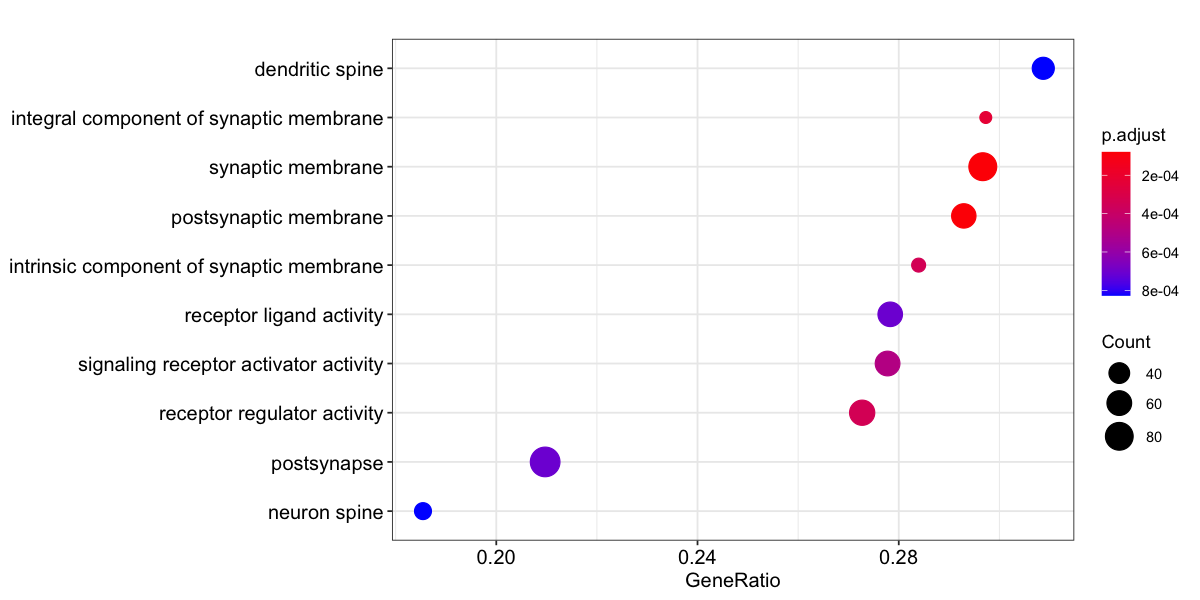

In [59]:
dotplot(gsea_out)

The size of the dot indicates how many members of the group are represented in the enrichment and the adjusted p-value is the Benjamini-Hochberg corrected p-value. `GeneRatio` is `k/n`, where for a given category (e.g. 'receptor regulator activity') `k` is the overlap of 'receptor regulator activity' genes in `gene_list` compared to all 'receptor regulator activity' genes in the org.db, where `n` is the overlap of all genes in `gene_list` compares to all genes in the org.db.

We can also use `enrichGO`, which takes a list of genes that are not ranked. We will separate out the up and down regulated genes from `res` first.

In [61]:
up_genes <- data.frame(res) %>% dplyr::filter(padj < 0.1 & log2FoldChange > 0)
down_genes <- data.frame(res) %>% dplyr::filter(padj < 0.1 & log2FoldChange < 0)

Then we can run `enrichGO` on the up and down regulated genes and make dotplots.

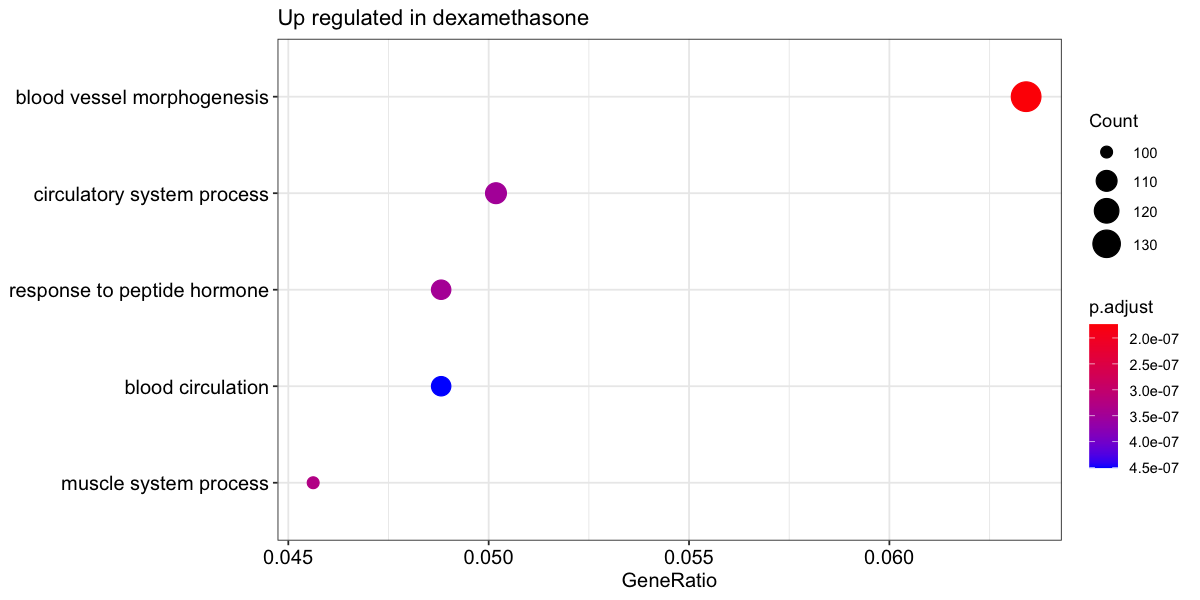

In [62]:
up_ego <- enrichGO(gene = rownames(up_genes),
          keyType = 'ENSEMBL',
          ont = 'BP',
          universe = rownames(res),
          OrgDb = orgdb,
          readable = TRUE)
dotplot(up_ego, showCategory = 5) + ggtitle('Up regulated in dexamethasone')

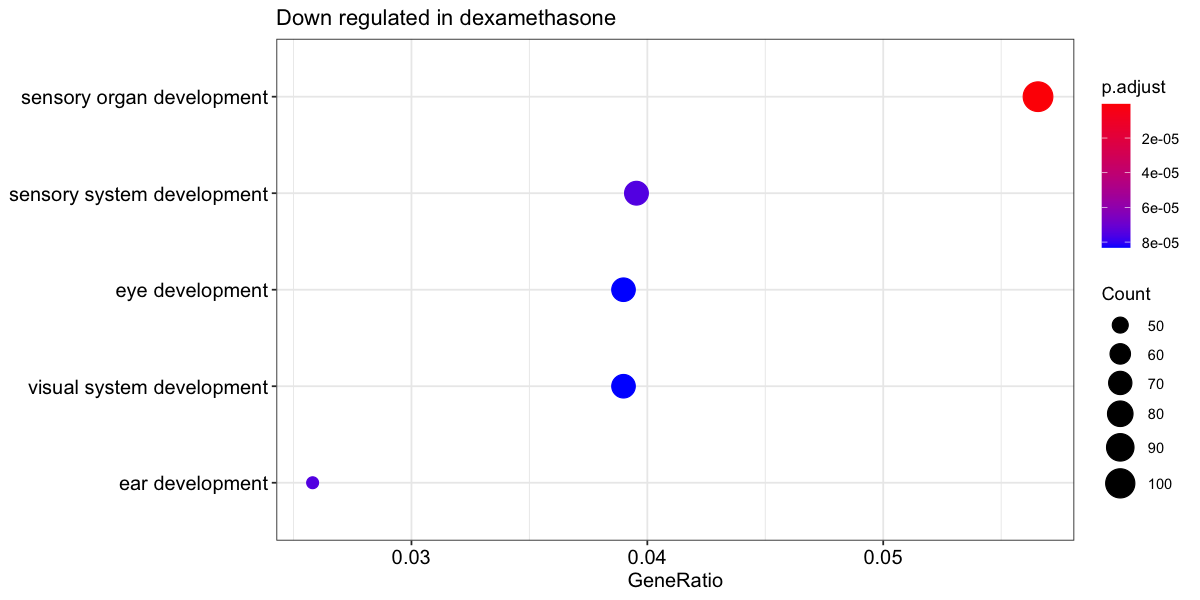

In [63]:
down_ego <- enrichGO(gene = rownames(down_genes),
          keyType = 'ENSEMBL',
          ont = 'BP',
          universe = rownames(res),
          OrgDb = orgdb,
          readable = TRUE)
dotplot(down_ego, showCategory = 5) + ggtitle('Down regulated in dexamethasone')

Note that in each of the calls to `enrichGO` above, I have specified the `universe` argument so that we are taking into consideration which genes were actually detected in our experiment. We also used the `ont = 'BP'` argument to tell `enrichGO` that we want to look at genes in the Biological Process category. We can also set the `showCategory = 5` argument in the call to `dotplot` to tell it to only show us the first 5 categories. The enrichment of `response to peptide hormone` in the up regulated genes makes sense, as dexamethasone is a corticosteroid hormone. 

In this example, we are running `enrichGO` on the up and down regulated genes separately, but it is also valid to run all of the differentially expressed genes together, depending on your research question. https://royalsocietypublishing.org/doi/10.1098/rsif.2013.0950

<div class="alert alert-block alert-success"><b>Exercise:</b> Try running `enrichGO` without setting the `universe` argument. How does this change your results? </div>

<div class="alert alert-block alert-success"><b>Exercise:</b> Try running `enrichGO` on all of the differentially expressed genes without pre-splitting into up and down regulated genes. How does this change your results? </div>